<a href="https://colab.research.google.com/github/ceydab/NLP_Projects/blob/main/LanguageClassificationwithNeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning for Natural Language Processing: Language Classification with Neural Networks
This notebook shows an example on how to use neural networks for language classification.

It starts with importing the dataset and splitting it correctly. Next, preprocessing, tokenization, vectorization, and training functions are introduced. Then the dataset is processed through these functions to get predictions for the test set. Then the classification report on the training set is observed and the parameters are adjusted to have an accuracy over 90%. When the goal is achieved, the prediction is made and the confusion matrix for the test set is printed.


In [1]:
import subprocess

# Installation on Google Colab
try:
    import google.colab
    subprocess.run(['python', '-m', 'pip', 'install', 'skorch'])
except ImportError:
    pass

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from skorch import NeuralNetClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import csv
import re
import string
from collections import defaultdict
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

In [3]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)

## Training a classifier and making predictions

In [6]:
# download dataset
!gdown 1QP6YuwdKFNUPpvhOaAcvv2Pcp4JMbIRs # x_train
!gdown 1QVo7PZAdiZKzifK8kwhEr_umosiDCUx6 # x_test
!gdown 1QbBeKcmG2ZyAEFB3AKGTgSWQ1YEMn2jl # y_train
!gdown 1QaZj6bI7_78ymnN8IpSk4gVvg-C9fA6X # y_test

Downloading...
From: https://drive.google.com/uc?id=1QP6YuwdKFNUPpvhOaAcvv2Pcp4JMbIRs
To: /content/x_train.txt
100% 64.1M/64.1M [00:00<00:00, 75.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1QVo7PZAdiZKzifK8kwhEr_umosiDCUx6
To: /content/x_test.txt
100% 65.2M/65.2M [00:00<00:00, 107MB/s]
Downloading...
From: https://drive.google.com/uc?id=1QbBeKcmG2ZyAEFB3AKGTgSWQ1YEMn2jl
To: /content/y_train.txt
100% 480k/480k [00:00<00:00, 11.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1QaZj6bI7_78ymnN8IpSk4gVvg-C9fA6X
To: /content/y_test.txt
100% 480k/480k [00:00<00:00, 11.5MB/s]


In [7]:
with open(f'x_train.txt') as f:
    x_train = f.read().splitlines()
with open(f'y_train.txt') as f:
    y_train = f.read().splitlines()
with open(f'x_test.txt') as f:
    x_test = f.read().splitlines()
with open(f'y_test.txt') as f:
    y_test = f.read().splitlines()

In [8]:
# combine x_train and y_train into one dataframe
train_df = pd.DataFrame({'text': x_train, 'label': y_train})

#combine x_test and y_test into one dataframe
test_df = pd.DataFrame({'text': x_test, 'label': y_test})

The data is obtained. Now we need to filter it for the desired languages, and split it correctly. Then, we will use labelencoder to convert labels to computationally readable inputs, and make sure that they are integers.

In [9]:
languages = ['afr', 'ara', 'aze', 'cat', 'ces', 'fin', 'fra', 'ell', 'hin', 'hun', 'isl', 'ita', 'jpn', 'kor', 'lit', 'msa', 'fas', 'pol', 'por', 'ron', 'eng', 'deu', 'nld', 'dan', 'swe', 'nob']
train_df = train_df[train_df['label'].isin(languages)]
test_df = test_df[test_df['label'].isin(languages)]

all_set = pd.concat((train_df,test_df), axis = 0)
X_train, X_test, y_train, y_test = train_test_split(all_set['text'], all_set['label'], train_size = 0.8, shuffle = True, stratify= all_set['label'])

train_df = pd.concat((X_train, y_train), axis=1)
test_df = pd.concat((X_test,y_test), axis =1)

print(train_df['label'].value_counts())
print(test_df['label'].value_counts())

label
aze    800
msa    800
ara    800
ita    800
isl    800
kor    800
swe    800
lit    800
por    800
nob    800
afr    800
hun    800
dan    800
nld    800
ces    800
eng    800
fra    800
ron    800
cat    800
fas    800
pol    800
hin    800
deu    800
jpn    800
ell    800
fin    800
Name: count, dtype: int64
label
nld    200
deu    200
fra    200
kor    200
pol    200
fin    200
lit    200
afr    200
ara    200
msa    200
ron    200
hun    200
isl    200
swe    200
por    200
ell    200
jpn    200
hin    200
fas    200
cat    200
dan    200
aze    200
ces    200
nob    200
eng    200
ita    200
Name: count, dtype: int64


In [10]:
# T: use your adjusted code to encode the labels here
le_fitted = LabelEncoder().fit(train_df['label'])
y_train, y_test = le_fitted.transform(train_df['label']), le_fitted.transform(test_df['label'])

In [11]:
y_train = y_train.astype(np.int64)
y_test = y_test.astype(np.int64)

We are done with the process needed for labels. Now, we will introduce the functions for preprocessing, tokenization, vectorizing, and training.

In [12]:
def preprocess(text):
  text = text.lower()
  text = re.sub(r'\d+', '', text)
  text = text.translate(str.maketrans("","", string.punctuation))
  text = text.strip()
  return text

In [13]:
def tokenize(preprocessed_text):
  stemmer= PorterStemmer()
  stem_text = []
  tokenized_text = word_tokenize(preprocessed_text)
  for word in tokenized_text:
    stemmed = stemmer.stem(word)
    stem_text.append(stemmed)
  return stem_text

In [14]:
def vectorize(X_train, X_test):
  X_train = X_train.apply(lambda x: ' '.join(x))
  X_test = X_test.apply(lambda x: ' '.join(x))
  count_vectorizer = CountVectorizer(analyzer='char', ngram_range=(2, 2), max_features=600, binary=True)
  train_count = count_vectorizer.fit_transform(X_train.to_numpy()).astype(np.float32)
  test_count = count_vectorizer.transform(X_test.to_numpy()).astype(np.float32)
  return train_count, test_count

Here, we define a neural network with two hidden layers, and input appropriate neuron numbers.

In [15]:
class ClassifierModule(nn.Module):
    def __init__(
            self,
            num_units=256,
            nonlin=F.relu,
            dropout = 0.5
    ):
        super(ClassifierModule, self).__init__()
        self.num_units = num_units
        self.nonlin = nonlin

        self.dense0 = nn.Linear(600, num_units)
        self.nonlin = nonlin
        self.dropout = nn.Dropout(dropout)
        self.dense1 = nn.Linear(num_units, 64)
        self.output = nn.Linear(64, 26)

    def forward(self, X, **kwargs):
      X = self.nonlin(self.dense0(X))
      X = self.dropout(X)
      X = F.relu(self.dense1(X))
      X = self.output(X)
      return X.squeeze(dim=1)

Now, we are at done with the functions. We will first define a NeuralNetClassifier that takes in any necessary input. Then, we will put X_train and X_test through the necessary steps. Lastly, we will fit the model to the training data.

In [21]:
net = NeuralNetClassifier(
    ClassifierModule,
    max_epochs=20,
    criterion=nn.CrossEntropyLoss(),
    lr=0.1,
    # device='cuda',  # comment this to train with CPU
)

In [16]:
X_train = X_train.apply(preprocess)
X_test = X_test.apply(preprocess)
X_train = X_train.apply(tokenize)
X_test = X_test.apply(tokenize)
X_train, X_test = vectorize(X_train,X_test)

In [22]:
net.fit(X_train, y_train)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.8443       0.6310        1.8625  4.4626
      2        1.1671       0.8719        0.6128  2.7570
      3        0.5196       0.9154        0.3230  2.6901
      4        0.3193       0.9587        0.2309  4.0729
      5        0.2350       0.9649        0.1889  2.7691
      6        0.1850       0.9678        0.1610  2.7325
      7        0.1599       0.9675        0.1450  2.7104
      8        0.1354       0.9714        0.1368  3.5537
      9        0.1176       0.9707        0.1297  3.2430
     10        0.1079       0.9728        0.1263  2.7254
     11        0.0996       0.9714        0.1224  2.7355
     12        0.0914       0.9716        0.1195  2.8321
     13        0.0827       0.9728        0.1166  3.9710
     14        0.0807       0.9745        0.1133  2.7310
     15        0.0752       0.9748        0.1138  2.7234
     16        0.0678       0.9

We have obtained an accuracy over 90% in the training loop. Now, we will send the test set into this and obtain predicted labels for the test set. Following, we will print the confusion matrix and the classification report.

In [28]:
y_pred = net.predict(X_test)

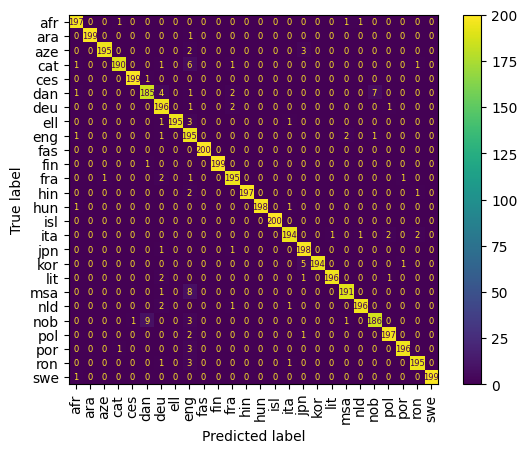

              precision    recall  f1-score   support

         afr       0.98      0.98      0.98       200
         ara       1.00      0.99      1.00       200
         aze       0.99      0.97      0.98       200
         cat       0.99      0.95      0.97       200
         ces       0.99      0.99      0.99       200
         dan       0.94      0.93      0.93       200
         deu       0.92      0.98      0.95       200
         ell       1.00      0.97      0.99       200
         eng       0.84      0.97      0.90       200
         fas       1.00      1.00      1.00       200
         fin       1.00      0.99      1.00       200
         fra       0.97      0.97      0.97       200
         hin       1.00      0.98      0.99       200
         hun       1.00      0.99      0.99       200
         isl       1.00      1.00      1.00       200
         ita       0.98      0.97      0.97       200
         jpn       0.95      0.99      0.97       200
         kor       1.00    

In [36]:
classes = le_fitted.inverse_transform(np.unique(y_train))
nn_confusion = confusion_matrix(y_test, y_pred)
plot_conf_matrix = ConfusionMatrixDisplay(nn_confusion, display_labels = classes)
plot_conf_matrix.plot(xticks_rotation = "vertical")
ax = plt.gca()

for text in ax.texts:
    text.set_fontsize(6)
plt.show()


In [38]:
print(classification_report(y_test,y_pred, target_names= classes))

              precision    recall  f1-score   support

         afr       0.98      0.98      0.98       200
         ara       1.00      0.99      1.00       200
         aze       0.99      0.97      0.98       200
         cat       0.99      0.95      0.97       200
         ces       0.99      0.99      0.99       200
         dan       0.94      0.93      0.93       200
         deu       0.92      0.98      0.95       200
         ell       1.00      0.97      0.99       200
         eng       0.84      0.97      0.90       200
         fas       1.00      1.00      1.00       200
         fin       1.00      0.99      1.00       200
         fra       0.97      0.97      0.97       200
         hin       1.00      0.98      0.99       200
         hun       1.00      0.99      0.99       200
         isl       1.00      1.00      1.00       200
         ita       0.98      0.97      0.97       200
         jpn       0.95      0.99      0.97       200
         kor       1.00    

We have obtained an average accuracy of 98%.

Before we finish, it should be noted that what seemed to be the most effective factor in the training of the neural network was the number of input neurons, which was obtained through vectorization. While the other parameters, such as number of hidden neurons, epochs, dropout rate, learning rate, and activation function were also effective, they were not as profound as the input characters.

It is also surprising that the model did not perform as well for english, as the model with linear classification. This might be due to the possibility of the inclusion of english words in the other language texts. As a consequence of input neurons, the model may be more successful in observing english characters.